### Transfer learning

In [61]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import datetime
import keras
import os
from keras.models import Sequential, load_model
from keras.layers import Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import img_to_array, load_img

In [62]:
# Loads Tensorboard
%load_ext tensorboard

# Clear any logs from previous runs
!rm -rf ./logs/

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


'rm' is not recognized as an internal or external command,
operable program or batch file.


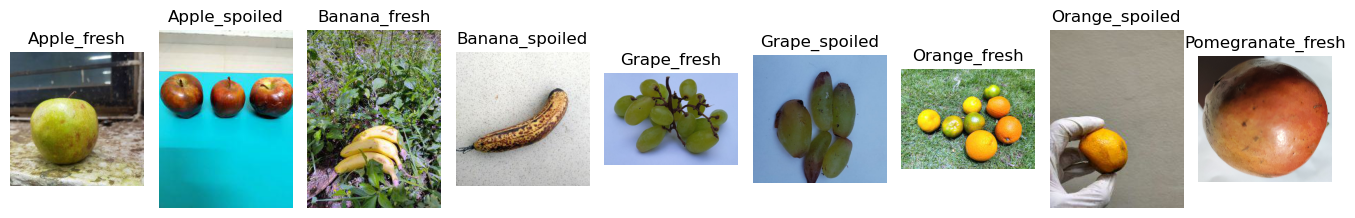

Size of image 100: (2626, 2772, 3)


In [63]:
# Specify the path for the datasets
dataset_dir = 'C:/Users/emanu/Documents/Programming/Python/Project/ADL/data'
train_path_quality = os.path.join(dataset_dir, 'Fruit-quality-dataset/Train')
test_path_quality = os.path.join(dataset_dir, 'Fruit-quality-dataset/Test')

qfruits = ['Apple_fresh', 'Apple_spoiled', 'Banana_fresh', 'Banana_spoiled', 'Grape_fresh', 'Grape_spoiled', 'Orange_fresh', 'Orange_spoiled', 'Pomegranate_fresh', 'Pomegranate_spolied']

# Which image in the folder
fruitnr = 100

plt.figure(figsize=(15, 10))
num_fruits = len(qfruits)

for i, fruit in enumerate(qfruits):
    fruit_path = os.path.join(train_path_quality, fruit)
    
    # Cycle through all subdirectories and files in the fruit_path
    for root, dirs, files in os.walk(fruit_path):
        # Get the file path of the desired image
        img_path = os.path.join(root, files[fruitnr - 1])
        
        # Load the image
        img = load_img(img_path)
        
        # Create a subplot for the current fruit image
        plt.subplot(1, num_fruits, i+1)
        plt.imshow(img)
        plt.title(fruit)
        plt.axis('off')
        break  # Break after processing the first image

plt.tight_layout()
plt.show()

print("Size of image {fruitnr}:".format(fruitnr=fruitnr), img_to_array(img).shape)

In [64]:
# Specify image dimensions for the network
img_height, img_width, channels = 100, 100, 3

# Define the training configurations
LEARNING_RATE = 0.0001
BATCH_SIZE = 16
SHEAR_RANGE = 0
ROTATION_RANGE = 0
ZOOM_RANGE = [1, 2]
OPTIMIZER = keras.optimizers.Adam(learning_rate=LEARNING_RATE)

# Choose transformations
train_datagen = ImageDataGenerator(
    rescale=1./255,
    fill_mode='constant',
    cval=255,
    shear_range=SHEAR_RANGE,
    rotation_range=ROTATION_RANGE,
    zoom_range=ZOOM_RANGE,
    validation_split=0.2,
    # preprocessing_function=add_monochromatic_blocks
) # Add random cropping, horizontal flipping, or adjusting brightness/contrast?
test_datagen  = ImageDataGenerator(rescale = 1./255)

# Convert the learning rate and shear range to strings without the decimal point
learning_rate_str = str(LEARNING_RATE).replace(".", "")
shear_range_str = str(SHEAR_RANGE).replace(".", "")

In [44]:
# Get the list of subdirectories and count the number of subdirectories
subdirectories = [f.path for f in os.scandir(train_path_quality) if f.is_dir()]
num_qclasses = len(subdirectories)

# Set model filename
model_name = f"fruit_model_lr{learning_rate_str}_bs{BATCH_SIZE}_sr{shear_range_str}_rr{ROTATION_RANGE}_zr{ZOOM_RANGE}.h5"
print(model_name)

best_model = load_model(os.path.join('360_models', model_name))

best_model.pop()  # Remove the last layer

best_model.add(Dense(num_qclasses, activation='softmax'))

best_model.summary(expand_nested=True, show_trainable=True)

fruit_model_lr00001_bs16_sr0_rr180_zr[1, 2].h5
Model: "sequential_1"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  Y          
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| input_2 (InputLayer)      [(None, 100, 100, 3)]     0         Y          |
|                                                                          |
| block1_conv1 (Conv2D)     (None, 100, 100, 64)      1792      Y          |
|                                                                          |
| block1_conv2 (Conv2D)     (None, 100, 100, 64)      36928     Y          |
|                                                                          |
| block1_pool (MaxPooling2D)  (None, 50, 50, 64)      0         Y          |
|                                                                          |
| block

In [66]:
# Generates batches of augmented training and test data from directory
train_generator_quality = train_datagen.flow_from_directory(
    train_path_quality,
    target_size = (img_height,img_width),
    batch_size = BATCH_SIZE,
    color_mode = "rgb",
    class_mode = "categorical",
    subset = "training")
validation_generator_quality = train_datagen.flow_from_directory(
    train_path_quality,
    target_size = (img_height,img_width),
    batch_size = BATCH_SIZE,
    color_mode = "rgb",
    class_mode = "categorical",
    subset = "validation")
test_generator_quality = test_datagen.flow_from_directory(
    test_path_quality,
    target_size = (img_height,img_width),
    batch_size = BATCH_SIZE,
    color_mode = "rgb",
    class_mode = "categorical")

Found 15693 images belonging to 10 classes.
Found 3918 images belonging to 10 classes.
Found 1215 images belonging to 10 classes.


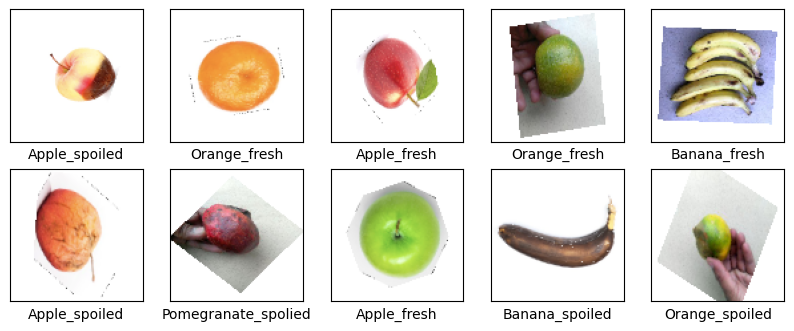

In [67]:
# Generate a batch of augmented images
augmented_images, labels = train_generator_quality.next()

# Limit the number of images to display
num_images = min(augmented_images.shape[0], 10)

# Plot the augmented images
plt.figure(figsize=(10, 10))
for i in range(num_images):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(augmented_images[i])
    plt.xlabel(qfruits[np.argmax(labels[i] == 1)])
plt.show()

In [68]:
# Reduces learning rate on performance plateau.
reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', # It monitors the validation loss to determine whether to reduce the learning rate.
    factor=0.1, # The learning rate is multiplied by this factor when triggered.
    patience=3, # Number of epochs with no improvement after which the learning rate will be reduced.
    min_lr=0.00001, # Lower bound on the learning rate.
    verbose=1 # Controls the level of detail in output messages.
)

model_name_quality = f"transfer_fruit_model_lr{learning_rate_str}_bs{BATCH_SIZE}_sr{shear_range_str}_rr{ROTATION_RANGE}_zr{ZOOM_RANGE}.h5"


# Create the "quality_models" subdirectory if it doesn't exist
if not os.path.exists("quality_models"):
    os.makedirs("quality_models")

# Specify the path for saving the best model
model_path = os.path.join("quality_models", model_name_quality)

# Save the best model the model after every epoch
checkpointer_callback = tf.keras.callbacks.ModelCheckpoint(
    model_path,
    save_weights_only=False,
    save_best_only=True,
    verbose=1
)

# Stops training when monitored metric stops improving.
earlyStop_callback = tf.keras.callbacks.EarlyStopping(
    patience=5,
    monitor='val_loss'
)

# TensorBoard logs for visualizing training progress.
log_dir = "logs/quality/" + model_name_quality + "_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1
)

callbacks = [
    checkpointer_callback,
    earlyStop_callback,
    tensorboard_callback,
    reduce_lr_callback
]

In [69]:
# Configures the model for training
best_model.compile(
    loss="categorical_crossentropy",
    optimizer = OPTIMIZER,
    metrics = ["Accuracy", "Recall", "Precision"]
)

In [70]:
# Train the model with specified settings and callbacks.
hist = best_model.fit(
    train_generator_quality,
    epochs = 50,
    validation_data = validation_generator_quality,
    callbacks = callbacks
)

Epoch 1/50
981/981 [==============================] - ETA: 0s - loss: 0.8117 - Accuracy: 0.7090 - recall: 0.6298 - precision: 0.8290
Epoch 1: val_loss improved from inf to 1.03235, saving model to quality_models\transfer_fruit_model_lr00001_bs16_sr0_rr180_zr[1, 2].h5
981/981 [==============================] - 1230s 1s/step - loss: 0.8117 - Accuracy: 0.7090 - recall: 0.6298 - precision: 0.8290 - val_loss: 1.0324 - val_Accuracy: 0.6565 - val_recall: 0.5426 - val_precision: 0.7560 - lr: 1.0000e-04
Epoch 2/50
981/981 [==============================] - ETA: 0s - loss: 0.3235 - Accuracy: 0.8977 - recall: 0.8769 - precision: 0.9173
Epoch 2: val_loss did not improve from 1.03235
981/981 [==============================] - 1237s 1s/step - loss: 0.3235 - Accuracy: 0.8977 - recall: 0.8769 - precision: 0.9173 - val_loss: 1.6384 - val_Accuracy: 0.5447 - val_recall: 0.5018 - val_precision: 0.5863 - lr: 1.0000e-04
Epoch 3/50
981/981 [==============================] - ETA: 0s - loss: 0.2238 - Accuracy:

In [71]:
# Load the best model
best_transfer_model = load_model(os.path.join('quality_models', model_name_quality))

# Evaluate the model
test_acc = best_transfer_model.evaluate(test_generator_quality, verbose=2)

# Get the evaluation results with 4 decimal places
loss = round(test_acc[0], 4)
accuracy = round(test_acc[1], 4)
recall = round(test_acc[2], 4)
precision = round(test_acc[3], 4)

# Write the results to a string
result_string = f"-Loss={loss:.4f}, Accuracy={accuracy:.4f}, Recall={recall:.4f}, Precision={precision:.4f}"

# Get the optimizer, learning rate, batch size, and transformations used
optimizer_name = best_model.optimizer.__class__.__name__
transformations = {
    key: value
    if key != 'rescale' else f"{1/value:.4f}"
    for key, value in train_datagen.__dict__.items()
    if key in ['rescale', 'fill_mode', 'cval', 'shear_range', 'rotation_range', 'zoom_range', 'validation_split']
    and value is not None and value != 0 and not callable(value)
}

# Write the additional information to a string
additional_info = (
    f"Optimizer={optimizer_name}, Learning Rate={LEARNING_RATE:.4f}, Batch Size={BATCH_SIZE},"
    f" Transformations={transformations}"
)

# Check if the file exists
if os.path.exists("model_acc.txt"):
    # If the file exists, open it in append mode
    with open("model_acc.txt", "a") as file:
        # Write the results to the file with 4 decimal places
        file.write(f"{result_string}, {additional_info}\n")
else:
    # If the file does not exist, create it and write the results
    with open("model_acc.txt", "w") as file:
        # Write the results to the file with 4 decimal places
        file.write(f"{result_string}, {additional_info}\n")

76/76 - 46s - loss: 1.5905 - Accuracy: 0.5317 - recall: 0.4765 - precision: 0.5699 - 46s/epoch - 604ms/step


In [37]:
# Launces application 'Tensorboard' that compiles all data from code-run in file path 'logs'
%tensorboard --logdir logs --port=6006 # 8008